In [42]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import os
import time
import pickle as pkl
import datetime

In [144]:
# Import and initialize Mountain Car Environment
# if render, uncomment
# env = gym.make('MountainCar-v0', render_mode = "human")

env = gym.make('MountainCar-v0')
np.random.seed(458)


In [145]:
# function for choosing action based on an epsilon greedy strategy
def chooseAction(pos, vel, q_table, epsilon):
    
    if np.random.random() < epsilon: # explore
        action = np.random.randint(0, env.action_space.n)
    else: # exploit
        action = np.argmax(q_table[pos][vel])

    return action

In [146]:
# function for state discretization
def getState(pos, env):
    
    newstate = (pos - env.observation_space.low)*np.array([10, 100])
    newstate = np.round(newstate, 0).astype(int)

    return newstate

In [147]:
# Define Q-learning function
def QLearning(env, learning, discount, epsilon, min_eps, episodes):

     # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()

    #writing to file
    path = f'./QLearning_data/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with Q-Learning on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()

            if steps > 500:
                break

            steps +=1    

            # Determine next action - epsilon greedy strategy
            action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

            # Get next state and reward
            state2, reward, done, info = env.step(action)[0:4] 
            
            # Discretize state2
            state2_adj = getState(state2, env)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                if steps < best_steps:
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (episode+1) % 100 == 0:    # prints out average reward every 100 ep
            print('Episode {} Average Reward: {}'.format(episode+1, ave_reward))
            
    env.close()

    # more writing
    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./QLearning_data/{timestamp}/log_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./QLearning_data/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, Q 


In [156]:
# Run Q-learning algorithm
avg_rewards, rewards, Q_table= QLearning(env, 0.2, 0.9, 0.8, 0, 100)
# print(avg_rewards, rewards, Q_table)

Episode 100 Average Reward: -484.0


In [157]:
avg_rewards2, rewards2, Q_table2 = QLearning(env, 0.2, 0.9, 0.8, 0, 2000)

Episode 100 Average Reward: -501.0
Episode 200 Average Reward: -500.97
Episode 300 Average Reward: -500.4
Episode 400 Average Reward: -496.96
Episode 500 Average Reward: -484.86
Episode 600 Average Reward: -477.91
Episode 700 Average Reward: -467.59
Episode 800 Average Reward: -475.74
Episode 900 Average Reward: -448.33
Episode 1000 Average Reward: -436.91
Episode 1100 Average Reward: -370.66
Episode 1200 Average Reward: -391.11
Episode 1300 Average Reward: -341.62
Episode 1400 Average Reward: -355.06
Episode 1500 Average Reward: -277.45
Episode 1600 Average Reward: -322.32
Episode 1700 Average Reward: -281.02
Episode 1800 Average Reward: -267.47
Episode 1900 Average Reward: -256.36
Episode 2000 Average Reward: -228.64


Text(0.5, 1.0, 'Average Reward vs Episodes')

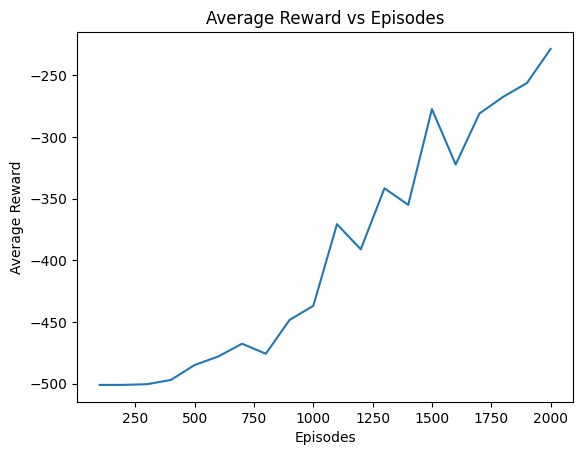

In [159]:
# Plot Average Rewards for Q-Learning
plt.plot(100*(np.arange(len(avg_rewards2)) + 1), avg_rewards2)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
# plt.savefig('rewards.jpg')     
# plt.close() 

Text(0.5, 1.0, 'Reward vs Episodes')

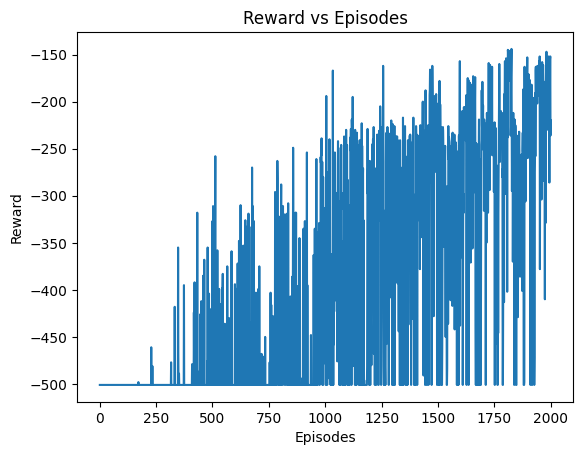

In [161]:
# Plot Rewards
plt.plot((np.arange(len(rewards2)) + 1), rewards2)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs Episodes')

#### SARSA 

In [152]:
# Define Sarsa function
def SARSA(env, learning, discount, epsilon, min_eps, episodes):

    # create timestamp, time marker, and data folder
    timestamp = datetime.datetime.now().strftime("%m_%d_%H_%M")
    start_time = time.time()
    last_time = time.time()
    
    # writing to file
    path = f'./SARSA_data/{timestamp}/'
    if not os.path.exists(path):
        os.makedirs(path)
    text = f'Training with SARSA on {episodes} episodes:\n\n'
    text = text + 'Parameters:\n'
    text = text + f"Learning Rate: {learning}\n"
    text = text + f"Discount: {discount}\n"
    text = text + f'Initial Epsilon: {epsilon}\n\n'

    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    reward_history = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run SARSA algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        steps = 0
        best_steps = np.inf
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = getState(state[0], env)

        # choose action based on state
        action = chooseAction(state_adj[0], state_adj[1] ,Q, epsilon)

        while done != True:   
            # Render environment for last five episodes
            # if episode >= (episodes - 5):
            #     env.render()

            if steps > 500:
                break

            steps +=1    

            # take next action and observe next state
            next_observation, reward, done, info = env.step(action)[0:4]
            state2 = getState(next_observation, env)

            # Get next action - epsilon greedy strategy
            next_action = chooseAction(state2[0], state2[1], Q, epsilon)

            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state2[0], state2[1], action] = reward
                if steps < best_steps: #record best steps
                    best_steps = steps

            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*(Q[state2[0], 
                                            state2[1],
                                            next_action]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2
            action = next_action
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_history.append(tot_reward)
        reward_list.append(tot_reward)
        
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (episode+1) % 100 == 0:    # print average reward for every 100 ep
            print('Episode {} Average Reward: {}'.format(episode+1, ave_reward))
            
    env.close()

    text = text + f'Max score: {max(reward_history)}\n'
    text = text + f'Minimum steps: {best_steps}\n\n'
    text = text + f"Final Epsilon: {epsilon}\n"
    with open(f'./SARSA_data/{timestamp}/log_{timestamp}.txt', 'w') as f:   
        f.write(text)

    # saving q_table
    with open(f'./SARSA_data/{timestamp}/qtable_{timestamp}.pickle', "wb") as f:
        pkl.dump(Q, f)

    return ave_reward_list, reward_history, Q 


In [142]:
avg_rewards3, rewards3, Q_table3 = SARSA(env, 0.2, 0.9, 0.8, 0, 5000)

Episode 100 Average Reward: -501.0
Episode 200 Average Reward: -500.7
Episode 300 Average Reward: -500.48
Episode 400 Average Reward: -496.97
Episode 500 Average Reward: -497.92
Episode 600 Average Reward: -500.04
Episode 700 Average Reward: -498.01
Episode 800 Average Reward: -494.02
Episode 900 Average Reward: -494.65
Episode 1000 Average Reward: -494.49
Episode 1100 Average Reward: -497.28
Episode 1200 Average Reward: -488.2
Episode 1300 Average Reward: -484.66
Episode 1400 Average Reward: -480.38
Episode 1500 Average Reward: -474.14
Episode 1600 Average Reward: -476.31
Episode 1700 Average Reward: -477.75
Episode 1800 Average Reward: -459.43
Episode 1900 Average Reward: -458.93
Episode 2000 Average Reward: -465.44
Episode 2100 Average Reward: -456.91
Episode 2200 Average Reward: -421.74
Episode 2300 Average Reward: -437.1
Episode 2400 Average Reward: -420.52
Episode 2500 Average Reward: -431.45
Episode 2600 Average Reward: -380.78
Episode 2700 Average Reward: -375.85
Episode 2800 A

In [155]:
avg_rewards4, rewards4, Q_table4 = SARSA(env, 0.2, 0.9, 0.8, 0, 2000)

Episode 100 Average Reward: -501.0
Episode 200 Average Reward: -499.05
Episode 300 Average Reward: -496.26
Episode 400 Average Reward: -496.31
Episode 500 Average Reward: -496.81
Episode 600 Average Reward: -486.48
Episode 700 Average Reward: -476.69
Episode 800 Average Reward: -454.86
Episode 900 Average Reward: -415.31
Episode 1000 Average Reward: -392.29
Episode 1100 Average Reward: -380.21
Episode 1200 Average Reward: -333.92
Episode 1300 Average Reward: -321.47
Episode 1400 Average Reward: -326.46
Episode 1500 Average Reward: -273.83
Episode 1600 Average Reward: -281.94
Episode 1700 Average Reward: -245.8
Episode 1800 Average Reward: -226.93
Episode 1900 Average Reward: -208.03
Episode 2000 Average Reward: -169.6


Text(0.5, 1.0, 'Average Reward vs Episodes')

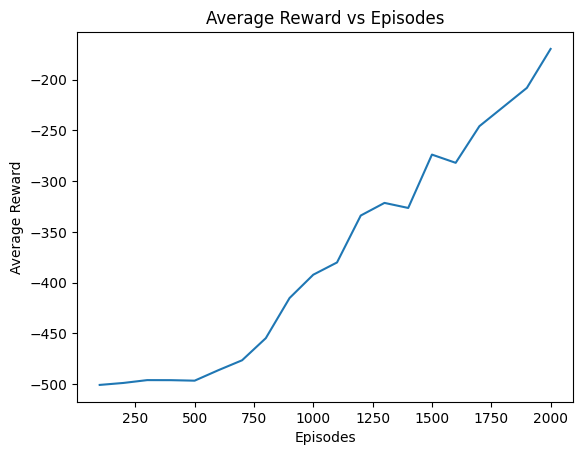

In [158]:
# Plot Average Rewards for SARSA
plt.plot(100*(np.arange(len(avg_rewards4)) + 1), avg_rewards4)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')